# Super Mario Bros Gym challenge
This is the example notebook for the seminar:

392241 Applied Cognitive Computing: Deep reinforcement learning with bounded rationality

# Setup

In [ ]:
! pip index versions pytorch

In [ ]:
! pip cache purge

In [ ]:
! pip uninstall gym --yes

In [ ]:

#! pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
! pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
! pip install gym-super-mario-bros opencv-python numpy tqdm --no-cache-dir
! pip install mediapy scipy --no-cache-dir
! pip install gym --no-cache-dir


## Checking the gpu that is provided by google colab.
If you don't see a gpu listed, or an error is shown, please click on the small dropdown arrow on the top right corner and choose "View Ressources" from the appearing menu.

From there you can click on "Change runtime type" on the bottom right.

In the appearing window, you should be able to select a "Hardware accelerator", which you will have to set to "GPU"

In [ ]:
! nvidia-smi

Fri Jun  9 17:43:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.79       Driver Version: 511.79       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P8     5W /  N/A |      0MiB /  6144MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# PPO Algorithm

Here we define the PPO Algorithm, that can be freely extended during the seminar.

The imports used for the PPO algorithm

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT,COMPLEX_MOVEMENT
from datetime import datetime
import cv2
from tqdm import tqdm
import numpy as np
from gym.wrappers import GrayScaleObservation

Setting the device to gpu if available

In [ ]:
device = torch.device(0)

In [ ]:
# set device to cpu or cuda
device = torch.device('cpu')
if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))

else:
    print("Device set to : cpu")
    raise ValueError("No GPU is set")

Device set to : NVIDIA GeForce GTX 1060


## ActorCritic
Here we define the actor critic agent that functions as our neural network.
To get a better understanding of the algorithm you can take a look at: https://theaisummer.com/Actor_critics/

## RolloutBuffer

In [ ]:
# The RolloutBuffer which keeps the training tuples.
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    # We clear the buffer after each training update
    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

In [ ]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

##Genetic Algorithm

##Helper Functions for the environments and rendering

In [ ]:
#renders given frames with mediapy and shows a video
def renderEnv(frames):
  import mediapy as media
  media.show_video(frames,fps=60//6)

#plot for visualizing results
def plotRewardandTime(avg_reward,avg_norm_reward,avg_length):
  import matplotlib.pyplot as plt
  import scipy
  from scipy.signal import savgol_filter
  x = np.linspace(0,len(avg_reward),len(avg_reward))

  fig, axs = plt.subplots(2, 2,figsize=(9,9))
  axs[0, 0].plot(x, savgol_filter(avg_reward,window_length=29,polyorder=3,mode='mirror') if len(avg_reward) > 30 else avg_reward)
  axs[0, 0].set_title("avg_reward")

  axs[0, 1].plot(x, savgol_filter(avg_norm_reward,window_length=29,polyorder=3,mode='mirror') if len(avg_norm_reward) > 30 else avg_norm_reward)
  axs[0, 1].set_title("avg_norm_reward")

  axs[1, 0].plot(x, savgol_filter(avg_length,window_length=29,polyorder=3,mode='mirror') if len(avg_length) > 30 else avg_length)
  axs[1, 0].set_title("avg_length")
  plt.show()

In [ ]:
# had to adjust code in time_limit.py to run on local machine: https://stackoverflow.com/questions/74060371/gym-super-mario-bros-7-3-0-valueerror-not-enough-values-to-unpack-expected
import gym

#This environment wrapper is used to stop a run if mario is stuck on a pipe
class DeadlockEnv(gym.Wrapper):
    def __init__(self, env, threshold=10):
        super().__init__(env)
        self.last_x_pos = 0
        self.count = 0
        self.threshold = threshold
        self.lifes = 3

    def reset(self, **kwargs):
        self.last_x_pos = 0
        self.count = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        x_pos = info['x_pos']

        if x_pos <= self.last_x_pos:
            self.count += 1
        else:
            self.count = 0
            self.last_x_pos = x_pos

        if info['life'] != self.lifes:
            self.last_x_pos = x_pos
            self.count = 0
            self.lifes = info['life']

        if self.count >= self.threshold:
            reward = -15
            done = True

        return state, reward, done, info

#skipframe wrapper
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        reward_out = 0
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            reward_out += reward
            if done:
                break
        reward_out /= max(1,i+1)

        # There was a bug here! Should return reward_out, not reward.
        #return obs, reward, done, info
        return obs, reward_out, done, info

#downsample wrapper to reduce dimensionality
def Downsample(ratio,state):
  (oldh, oldw, oldc) = state.shape
  newshape = (oldh//ratio, oldw//ratio, oldc)
  frame = cv2.resize(state, (newshape[0], newshape[1]), interpolation=cv2.INTER_AREA)
  return frame

#small function to change rgb images to grayscale
def GrayScale(state):
  return cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)



#Training

In [ ]:
import random
# a Gene is a specific list of actions that determine the agent's behavior at each possible time step
class Gene:
    def __init__(self, action_dim, mutation_rate_min, mutation_rate_max, actions=[]):
        self.actions = actions
        self.time = 0
        self.reward = 0
        self.mutation_rate_min = mutation_rate_min
        self.mutation_rate_max = mutation_rate_max
        self.action_dim = action_dim
    # return the action for the current time step, or a random action if there is no action for the current time step
    def act(self):
        self.time += 1
        if (self.time - 1) < len(self.actions):
            return self.actions[self.time - 1]
        action = random.randrange(0, self.action_dim)
        self.actions.append(action)
        return action
    # return a copy of this Gene where some actions have been replaced by random actions with probability mutation_rate
    def mutate(self):
        #mutation_rates = np.linspace(self.mutation_rate_min, mutation_rate_max, len(self.actions))
        mutations_len = min(len(self.actions), 100)
        same_len = len(self.actions) - mutations_len
        mutation_rates = ([0]  * same_len) +  list(np.logspace(self.mutation_rate_min, mutation_rate_max, mutations_len, base=np.exp(1)))
        mutated_actions = [self.actions[i] if random.random() >= mutation_rates[i] else random.randrange(0, self.action_dim) for i in range(len(self.actions))]
        return Gene(self.action_dim, self.mutation_rate_min, self.mutation_rate_max, mutated_actions)

2 genes updated
--------------------------------
Epoch 113 done:
Statistics:

Reward for this episode: 356.6666666666665
Length of this episode: 271

Average total reward: 254.25333333333322
Average normalized reward: 1.2456124986179982
Average length: 204.36
--------------------------------


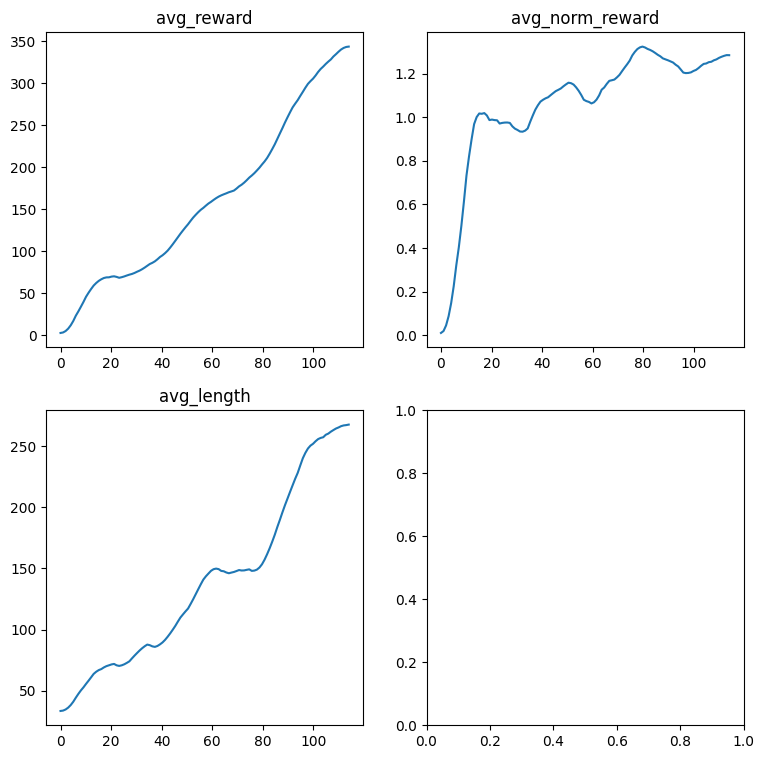

timestep: 138105 reward: 1.2411791242842547:   1%|▎                             | 114/10001 [29:47<43:03:56, 15.68s/it]


KeyboardInterrupt: 

In [ ]:

from IPython.core.display import clear_output



state_dim = 15360                     # state space dimension
has_continuous_action_space = False   # the mario environment doesn't have a continuous action space
action_std = None                     # we don't change the action distribution
#frameskip = 4
frameskip = 6                         # the frameskip value of the environment
down_sample_rate = 4                  # downsample rate. Calculated as: original_dimension/down_sample_rate
frame_stack = 4                       # frame stacking value
update_steps = 2048                   # how long we collect steps before updating
x_dim = 64
y_dim = 60

env = gym_super_mario_bros.make('SuperMarioBros-1-4-v1')  #the environment. v0 is with original background, v1 has the background removed
env = JoypadSpace(env, COMPLEX_MOVEMENT)              #The Joypadspace sets the available actions. We use COMPLEX_MOVEMENT to allow to go down in pipes.
env = SkipFrame(env, skip=frameskip)                  #Skipframewrapper to skip some frames
env = DeadlockEnv(env,threshold=5)                   #Deadlock environment wrapper to stop the game if mario is stuck at a pipe


action_dim = env.action_space.n # action space dimension

# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")

#some helper variables
time_step = 0
#max_training_epochs = int(1e9)
max_training_epochs = 10000
max_ep_len = 10000
update_timestep = max_ep_len

# We mount the google drive to save and load PPO states.
#from google.colab import drive
#drive.mount('/content/gdrive')

# If an agent is saved you can uncomment the following line to load the weights.
#ppo_agent.load("/content/gdrive/My Drive/ppo.save")

avg_reward = []
avg_length = []
avg_norm_reward = []
updates = 0

mutation_rate_min = np.log(0.001) #replace oldest action with 0.1% probability (exponential scaling)
mutation_rate_max = np.log(0.2) #replace newest action with 20% probability (exponential scaling)
num_genes = 20
genes_old = []
genes_new = [Gene(action_dim, mutation_rate_min, mutation_rate_max) for i in range(num_genes)]
best_gene = None
best_frames = []
rewards = [-200 * (num_genes * 2)]

tbar = tqdm(range(max_training_epochs + 1))
for i in tbar:
    max_reward = max(rewards)
    rewards = rewards[(num_genes // 2):]
    for gene in genes_new:
        # first we reset the state
        state = env.reset()
        current_ep_reward = 0
        frames = []
        # the collection loop
        for t in range(1, max_ep_len):

            action = gene.act()

            # performing the action and receiving the information from the environments
            state, reward, done, _ = env.step(action)

            frames.append(state.copy())

            time_step +=1
            current_ep_reward += reward

            # if the run is done we break the loop
            if done:
                rewards.append(current_ep_reward)
                if current_ep_reward > max_reward:
                    max_reward = current_ep_reward
                    best_gene = gene
                    best_frames = frames
                break

    # We collect information every run and write them to the console
    current_ep_reward = max_reward
    t = best_gene.time + 1
    avg_reward.append(current_ep_reward)
    avg_length.append(t)
    tbar.set_description("timestep: " + str(time_step) +" reward: "+str(np.asarray(avg_norm_reward[-50:]).mean()))
    avg_norm_reward.append(current_ep_reward/max(1,t))

    # Keep the best performing 50% of all agents, and add a mutation of each of them
    #see parallel sort: https://www.adamsmith.haus/python/answers/how-to-sort-two-lists-together-in-python
    genes = genes_old + genes_new
    gene_indices = [i for i in range(num_genes)]
    rewards, gene_indices = [list(tuple) for tuple in zip(*sorted(zip(rewards, gene_indices)))]
    gene_indices = gene_indices[(num_genes // 2):]
    # https://stackoverflow.com/questions/10543303/number-of-values-in-a-list-greater-than-a-certain-number
    num_updated_genes = sum(i >= 10 for i in gene_indices)
    genes_old = [genes[j] for j in gene_indices]
    #genes_old = [Gene(action_dim, mutation_rate_min, mutation_rate_max, genes[j].actions) for j in gene_indices]
    genes_new = [genes_old[j].mutate() for j in range(len(genes_old))]

    # Every 50 epochs we render the current environment
    #if i % 50 == 0 and len(frames) > 0:
    clear_output(wait=True)
    print(str(num_updated_genes) + " genes updated")
    print("--------------------------------")
    print("Epoch",i,"done:")
    #print("Update iterations:",updates)
    print("Statistics:")
    print("")
    print("Reward for this episode:",current_ep_reward)
    print("Length of this episode:",t)
    print("")
    print("Average total reward:",np.asarray(avg_reward[-50:]).mean())
    print("Average normalized reward:",np.asarray(avg_norm_reward[-50:]).mean())
    print("Average length:",np.asarray(avg_length[-50:]).mean())
    print("--------------------------------")
    plotRewardandTime(avg_reward,avg_norm_reward,avg_length)
    renderEnv(best_frames)






env.close()